# NYC Motor Vehicle Collision Injury Prediction Pipeline

This notebook implements a reproducible data pipeline that predicts whether a NYC collision results in any injuries or fatalities.

**Research Question:** Given collision context (time, location, vehicle types, contributing factors), can we predict if a crash will cause at least one injury or fatality?

## Section 1: Setup and Configuration


In [43]:
# Core libraries
import pandas as pd
import numpy as np
import sqlite3
from pathlib import Path

# Visualization

import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn - preprocessing and pipelines
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors

# Sklearn - models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Sklearn - evaluation
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix, classification_report
)
from dotenv import load_dotenv
import os
load_dotenv()

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
sns.set_style('whitegrid')

print("All imports successful!")


All imports successful!


In [44]:
# =============================================================================
# CONFIGURATION
# =============================================================================

db_url = os.getenv("FILE_PATH")
# File paths
RAW_DATA_PATH = db_url
DB_PATH = "collisions.db"

# Train/test split configuration (time-based)
TRAIN_YEARS = list(range(2012, 2025))  # 2012-2024
TEST_YEAR = 2025

# Feature configuration
CATEGORICAL_FEATURES = [
    'borough',
    'hour',
    'day_of_week', 
    'is_weekend',
    'is_rush_hour',
    'vehicle_type_1',
    'contributing_factor_1'
]

NUMERIC_FEATURES = [
    'num_vehicles'
]

TARGET = 'severe'

# Vehicle type consolidation mapping (raw values → standardized categories)
VEHICLE_TYPE_MAP = {
    # Sedan/Passenger
    'Sedan': 'Sedan', '4 dr sedan': 'Sedan', '2 dr sedan': 'Sedan',
    'PASSENGER VEHICLE': 'Sedan', '3-Door': 'Sedan',
    # SUV/Station Wagon
    'Station Wagon/Sport Utility Vehicle': 'SUV', 
    'SPORT UTILITY / STATION WAGON': 'SUV',
    # Taxi
    'Taxi': 'Taxi', 'TAXI': 'Taxi', 'Livery Vehicle': 'Taxi',
    # Truck
    'Pick-up Truck': 'Truck', 'Box Truck': 'Truck', 
    'LARGE COM VEH(6 OR MORE TIRES)': 'Truck', 'Tractor Truck Diesel': 'Truck',
    'Flat Bed': 'Truck', 'Dump': 'Truck', 'Tow Truck / Wrecker': 'Truck',
    # Van
    'VAN': 'Van', 'Van': 'Van', 'AMBULANCE': 'Van',
    # Bus
    'Bus': 'Bus', 'BUS': 'Bus',
    # Motorcycle
    'Motorcycle': 'Motorcycle', 'MOTORCYCLE': 'Motorcycle', 'Motorbike': 'Motorcycle',
    # Bike
    'Bike': 'Bike', 'E-Bike': 'Bike', 'E-Scooter': 'Bike',
    # Other/Unknown
    'OTHER': 'Other', 'UNKNOWN': 'Unknown', 'Unknown': 'Unknown'
}

# Contributing factor consolidation mapping
CONTRIBUTING_FACTOR_MAP = {
    'Driver Inattention/Distraction': 'Distraction',
    'Failure to Yield Right-of-Way': 'Failure to Yield',
    'Following Too Closely': 'Following Too Closely',
    'Backing Unsafely': 'Improper Maneuver',
    'Passing or Lane Usage Improper': 'Improper Maneuver',
    'Passing Too Closely': 'Improper Maneuver',
    'Turning Improperly': 'Improper Maneuver',
    'Unsafe Lane Changing': 'Improper Maneuver',
    'Fatigued/Drowsy': 'Fatigue',
    'Traffic Control Disregarded': 'Traffic Violation',
    'Unsafe Speed': 'Speeding',
    'Alcohol Involvement': 'Alcohol/Drugs',
    'Drugs (illegal)': 'Alcohol/Drugs',
    'Driver Inexperience': 'Inexperience',
    'Unspecified': 'Unspecified',
    'Other Vehicular': 'Other'
}

print("Configuration loaded:")
print(f"  Raw data: {RAW_DATA_PATH}")
print(f"  Database: {DB_PATH}")
print(f"  Train years: {TRAIN_YEARS[0]}-{TRAIN_YEARS[-1]}")
print(f"  Test year: {TEST_YEAR}")


Configuration loaded:
  Raw data: /Users/adamyasingh/Documents/rutgers/fall-25/data-management/course-project/NYPD Motor Vehicle Collisions Dec 3 2025.csv
  Database: collisions.db
  Train years: 2012-2024
  Test year: 2025


## Section 2: Data Loading and Cleaning

Load the raw CSV, parse dates, handle missing values, and create the target variable.


In [45]:
# Load raw data
df_raw = pd.read_csv(RAW_DATA_PATH, low_memory=False)

print(f"Loaded {len(df_raw):,} rows × {len(df_raw.columns)} columns")
print(f"\nColumns: {list(df_raw.columns)}")


Loaded 2,224,642 rows × 29 columns

Columns: ['CRASH DATE', 'CRASH TIME', 'BOROUGH', 'ZIP CODE', 'LATITUDE', 'LONGITUDE', 'LOCATION', 'ON STREET NAME', 'CROSS STREET NAME', 'OFF STREET NAME', 'NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED', 'NUMBER OF PEDESTRIANS INJURED', 'NUMBER OF PEDESTRIANS KILLED', 'NUMBER OF CYCLIST INJURED', 'NUMBER OF CYCLIST KILLED', 'NUMBER OF MOTORIST INJURED', 'NUMBER OF MOTORIST KILLED', 'CONTRIBUTING FACTOR VEHICLE 1', 'CONTRIBUTING FACTOR VEHICLE 2', 'CONTRIBUTING FACTOR VEHICLE 3', 'CONTRIBUTING FACTOR VEHICLE 4', 'CONTRIBUTING FACTOR VEHICLE 5', 'COLLISION_ID', 'VEHICLE TYPE CODE 1', 'VEHICLE TYPE CODE 2', 'VEHICLE TYPE CODE 3', 'VEHICLE TYPE CODE 4', 'VEHICLE TYPE CODE 5']


## Exploratory Data Analysis

For detailed exploratory analysis including data distributions, missing value analysis, and summary statistics, see **`EDA.ipynb`**.

**Key findings from EDA:**
- **2.2M+ collision records** from July 2012 to November 2025
- **24.4% of collisions** result in injury or fatality (moderate class imbalance, 3.1:1 ratio)
- **30.6% of borough values** were missing (imputed via KNN spatial voting)
- **1,842 unique vehicle types** consolidated to ~10 categories using mapping
- **Top contributing factor**: Driver Inattention/Distraction (20.3%)
- **Declining trend**: Collisions peaked in 2018 (231K) and have declined since


In [46]:
# =============================================================================
# DATA CLEANING
# =============================================================================

df = df_raw.copy()

# 1. Parse date and time
df['crash_datetime'] = pd.to_datetime(
    df['CRASH DATE'] + ' ' + df['CRASH TIME'], 
    format='%m/%d/%Y %H:%M'
)
df['year'] = df['crash_datetime'].dt.year

# 2. Handle missing values
# Borough and ZIP Code: preserve NULLs for KNN imputation (will fill with "Unknown" after imputation)
df['borough'] = df['BOROUGH']
df['zip_code'] = df['ZIP CODE'].astype(str).replace('nan', np.nan)  # Convert string 'nan' to actual NaN

# Coordinates: create flag for missing
df['coords_missing'] = df['LATITUDE'].isna() | df['LONGITUDE'].isna()
df['latitude'] = df['LATITUDE']
df['longitude'] = df['LONGITUDE']

# Contributing factors: fill with "Unknown"
for i in range(1, 6):
    col = f'CONTRIBUTING FACTOR VEHICLE {i}'
    df[f'contributing_factor_{i}'] = df[col].fillna('Unknown') if col in df.columns else 'Unknown'

# Vehicle types: fill with "Unknown"
for i in range(1, 6):
    col = f'VEHICLE TYPE CODE {i}'
    df[f'vehicle_type_{i}'] = df[col].fillna('Unknown') if col in df.columns else 'Unknown'

# 3. Create target variable: SEVERE = 1 if any injury or fatality
df['num_injured'] = df['NUMBER OF PERSONS INJURED'].fillna(0)
df['num_killed'] = df['NUMBER OF PERSONS KILLED'].fillna(0)
df['severe'] = ((df['num_injured'] + df['num_killed']) > 0).astype(int)

# 4. Keep collision ID
df['collision_id'] = df['COLLISION_ID']

print("Data cleaning complete!")
print(f"  Rows: {len(df):,}")
print(f"  Date range: {df['crash_datetime'].min().strftime('%Y-%m-%d')} to {df['crash_datetime'].max().strftime('%Y-%m-%d')}")


Data cleaning complete!
  Rows: 2,224,642
  Date range: 2012-07-01 to 2025-11-29


In [47]:
# =============================================================================
# VALIDATION CHECK: After Data Cleaning
# =============================================================================

print("=" * 70)
print("VALIDATION: After Data Cleaning")
print("=" * 70)

print(f"\nDataset Overview:")
print(f"  Total rows: {len(df):,}")
print(f"  Total columns: {len(df.columns)}")

# Missing data analysis
print(f"\nMissing Data Summary:")
missing_cols = ['borough', 'zip_code', 'latitude', 'longitude']
for col in missing_cols:
    if col in df.columns:
        missing_count = df[col].isna().sum()
        missing_pct = (missing_count / len(df)) * 100
        print(f"  {col:15} | Missing: {missing_count:>8,} ({missing_pct:>5.1f}%)")

# Coordinates status
if 'coords_missing' in df.columns:
    missing_coords = df['coords_missing'].sum()
    print(f"  {'coords_missing':15} | Missing: {missing_coords:>8,} ({(missing_coords/len(df)*100):>5.1f}%)")

# Borough distribution
print(f"\nBorough Distribution:")
if 'borough' in df.columns:
    borough_counts = df['borough'].value_counts(dropna=False)
    for borough, count in borough_counts.head(10).items():
        pct = (count / len(df)) * 100
        borough_display = str(borough) if not pd.isna(borough) else 'NULL'
        print(f"  {borough_display:20} | {count:>8,} ({pct:>5.1f}%)")

# Leading Contributing Factors
print(f"\nTop Contributing Factors (Vehicle 1):")
if 'contributing_factor_1' in df.columns:
    cf1_counts = df['contributing_factor_1'].value_counts()
    for factor, count in cf1_counts.head(10).items():
        pct = (count / len(df)) * 100
        print(f"  {str(factor):40} | {count:>8,} ({pct:>5.1f}%)")

print(f"\nTop Contributing Factors (Vehicle 2):")
if 'contributing_factor_2' in df.columns:
    cf2_counts = df['contributing_factor_2'].value_counts()
    for factor, count in cf2_counts.head(10).items():
        pct = (count / len(df)) * 100
        print(f"  {str(factor):40} | {count:>8,} ({pct:>5.1f}%)")

# Leading Vehicle Types
print(f"\nTop Vehicle Types (Vehicle 1):")
if 'vehicle_type_1' in df.columns:
    vt1_counts = df['vehicle_type_1'].value_counts()
    for vtype, count in vt1_counts.head(10).items():
        pct = (count / len(df)) * 100
        print(f"  {str(vtype):40} | {count:>8,} ({pct:>5.1f}%)")

print(f"\nTop Vehicle Types (Vehicle 2):")
if 'vehicle_type_2' in df.columns:
    vt2_counts = df['vehicle_type_2'].value_counts()
    for vtype, count in vt2_counts.head(10).items():
        pct = (count / len(df)) * 100
        print(f"  {str(vtype):40} | {count:>8,} ({pct:>5.1f}%)")

# Target variable distribution
print(f"\nTarget Variable (severe):")
if 'severe' in df.columns:
    severe_counts = df['severe'].value_counts()
    for val, count in severe_counts.items():
        pct = (count / len(df)) * 100
        label = "Injury/Fatal" if val == 1 else "No Injury"
        print(f"  {label:20} ({val}) | {count:>8,} ({pct:>5.1f}%)")

print("\n" + "=" * 70)


VALIDATION: After Data Cleaning

Dataset Overview:
  Total rows: 2,224,642
  Total columns: 50

Missing Data Summary:
  borough         | Missing:  681,099 ( 30.6%)
  zip_code        | Missing:  681,376 ( 30.6%)
  latitude        | Missing:  240,389 ( 10.8%)
  longitude       | Missing:  240,389 ( 10.8%)
  coords_missing  | Missing:  240,389 ( 10.8%)

Borough Distribution:
  NULL                 |  681,099 ( 30.6%)
  BROOKLYN             |  494,784 ( 22.2%)
  QUEENS               |  413,609 ( 18.6%)
  MANHATTAN            |  341,956 ( 15.4%)
  BRONX                |  228,562 ( 10.3%)
  STATEN ISLAND        |   64,632 (  2.9%)

Top Contributing Factors (Vehicle 1):
  Unspecified                              |  744,354 ( 33.5%)
  Driver Inattention/Distraction           |  451,764 ( 20.3%)
  Failure to Yield Right-of-Way            |  133,292 (  6.0%)
  Following Too Closely                    |  119,471 (  5.4%)
  Backing Unsafely                         |   81,174 (  3.6%)
  Other Vehi

In [48]:
# =============================================================================
# BOROUGH & ZIP_CODE IMPUTATION (KNN SPATIAL VOTING)
# =============================================================================

def impute_location_labels_knn(df, k=50, min_neighbors=10):
    """
    Impute missing borough and zip_code using K-Nearest Neighbors spatial voting.
    
    Strategy:
    - Split data into known_locations (has lat, lon, borough, zip) and 
      missing_location_labels (has lat, lon but missing borough and/or zip)
    - Use KNN to find k nearest known neighbors for each missing row
    - Assign borough = mode(neighbor boroughs), zip_code = mode(neighbor zip_codes)
    - If < min_neighbors found, mark as "Unknown"
    
    Args:
        df: DataFrame with 'latitude', 'longitude', 'borough', 'zip_code', 'collision_id'
        k: Number of nearest neighbors to consider (default: 50)
        min_neighbors: Minimum neighbors required for imputation (default: 10)
    
    Returns:
        DataFrame with imputed borough/zip_code and 'imputation_method' column
    """
    df = df.copy()
    
    # Create boolean masks for missing coordinates
    has_coords = df['latitude'].notna() & df['longitude'].notna()
    
    # Split into known and missing location labels
    # Known: has coordinates AND both borough and zip_code are non-null
    known_mask = (
        has_coords & 
        df['borough'].notna() & 
        df['zip_code'].notna() &
        (df['zip_code'] != 'nan')  # Also exclude string 'nan'
    )
    
    # Missing labels: has coordinates BUT missing borough and/or zip_code
    missing_mask = (
        has_coords & 
        (df['borough'].isna() | df['zip_code'].isna() | (df['zip_code'] == 'nan'))
    )
    
    known_locations = df[known_mask].copy()
    missing_location_labels = df[missing_mask].copy()
    
    print("=" * 70)
    print("KNN SPATIAL VOTING IMPUTATION")
    print("=" * 70)
    print(f"Known locations (has lat, lon, borough, zip): {len(known_locations):,}")
    print(f"Missing location labels (has lat, lon, missing borough/zip): {len(missing_location_labels):,}")
    
    if len(known_locations) == 0:
        print("WARNING: No known locations found. Cannot perform imputation.")
        df['imputation_method'] = None
        return df
    
    if len(missing_location_labels) == 0:
        print("No missing location labels to impute.")
        df['imputation_method'] = None
        return df
    
    # Prepare coordinates for KNN
    # Use Euclidean distance on lat/lon (acceptable for NYC-scale distances)
    known_coords = known_locations[['latitude', 'longitude']].values
    missing_coords = missing_location_labels[['latitude', 'longitude']].values
    
    # Fit KNN model on known locations
    print(f"\nFitting KNN model (k={k}) on {len(known_coords):,} known locations...")
    nn = NearestNeighbors(n_neighbors=min(k, len(known_locations)), metric='euclidean', n_jobs=-1)
    nn.fit(known_coords)
    
    # Find neighbors for missing locations (vectorized)
    print(f"Finding neighbors for {len(missing_coords):,} missing location labels...")
    distances, indices = nn.kneighbors(missing_coords)
    
    # Initialize imputation method column
    df['imputation_method'] = None
    
    # Vectorized imputation using mode voting
    print("Performing spatial voting imputation...")
    
    # Get indices of missing rows in original dataframe
    missing_indices = missing_location_labels.index.values
    
    # For each missing row, get its neighbors and compute mode
    imputed_borough = []
    imputed_zip = []
    imputed_method = []
    
    for i, missing_idx in enumerate(missing_indices):
        neighbor_indices = indices[i]
        n_neighbors = len(neighbor_indices)
        
        if n_neighbors < min_neighbors:
            # Not enough neighbors - mark as Unknown
            imputed_borough.append('Unknown')
            imputed_zip.append('Unknown')
            imputed_method.append(None)
        else:
            # Get neighbor boroughs and zip codes
            neighbor_df_indices = known_locations.index[neighbor_indices]
            neighbor_boroughs = df.loc[neighbor_df_indices, 'borough'].values
            neighbor_zips = df.loc[neighbor_df_indices, 'zip_code'].values
            
            # Remove any NaN values from neighbors
            neighbor_boroughs = neighbor_boroughs[~pd.isna(neighbor_boroughs)]
            neighbor_zips = neighbor_zips[~pd.isna(neighbor_zips)]
            neighbor_zips = neighbor_zips[neighbor_zips != 'nan']
            
            # Compute mode (most frequent value)
            if len(neighbor_boroughs) > 0:
                borough_mode = pd.Series(neighbor_boroughs).mode()
                imputed_borough_val = borough_mode.iloc[0] if len(borough_mode) > 0 else 'Unknown'
            else:
                imputed_borough_val = 'Unknown'
            
            if len(neighbor_zips) > 0:
                zip_mode = pd.Series(neighbor_zips).mode()
                imputed_zip_val = zip_mode.iloc[0] if len(zip_mode) > 0 else 'Unknown'
            else:
                imputed_zip_val = 'Unknown'
            
            # Only impute if original value is missing (check for NULLs only)
            original_borough = df.loc[missing_idx, 'borough']
            original_zip = df.loc[missing_idx, 'zip_code']
            
            # Check if borough needs imputation
            borough_needs_imputation = pd.isna(original_borough)
            if borough_needs_imputation:
                imputed_borough.append(imputed_borough_val)
            else:
                imputed_borough.append(original_borough)
            
            # Check if zip_code needs imputation (handle both NULL and string 'nan')
            zip_needs_imputation = pd.isna(original_zip) or (isinstance(original_zip, str) and original_zip == 'nan')
            if zip_needs_imputation:
                imputed_zip.append(imputed_zip_val)
            else:
                imputed_zip.append(original_zip)
            
            # Mark method if we actually imputed something
            if borough_needs_imputation or zip_needs_imputation:
                imputed_method.append('knn_spatial_vote')
            else:
                imputed_method.append(None)
    
    # Update dataframe with imputed values
    df.loc[missing_indices, 'borough'] = imputed_borough
    df.loc[missing_indices, 'zip_code'] = imputed_zip
    df.loc[missing_indices, 'imputation_method'] = imputed_method
    
    # Fill remaining NULLs with "Unknown"
    df['borough'] = df['borough'].fillna('Unknown')
    df['zip_code'] = df['zip_code'].fillna('Unknown').astype(str)
    df['zip_code'] = df['zip_code'].replace('nan', 'Unknown')
    
    return df

# Apply KNN imputation
df = impute_location_labels_knn(df, k=50, min_neighbors=10)

# Validation output
print("\n" + "=" * 70)
print("IMPUTATION VALIDATION")
print("=" * 70)

# Count imputed rows
imputed_mask = df['imputation_method'] == 'knn_spatial_vote'
n_imputed = imputed_mask.sum()

# Count remaining "Unknown" boroughs and zip codes
n_unknown_borough = (df['borough'] == 'Unknown').sum()
n_unknown_zip = (df['zip_code'] == 'Unknown').sum()

# Count original missing (before imputation would have been)
has_coords = df['latitude'].notna() & df['longitude'].notna()
n_with_coords = has_coords.sum()

print(f"\nRows with coordinates: {n_with_coords:,}")
print(f"\nBoroughs:")
print(f"  Filled via KNN: {n_imputed:,}")
print(f"  Remaining 'Unknown': {n_unknown_borough:,} ({n_unknown_borough/len(df)*100:.1f}%)")

print(f"\nZip Codes:")
print(f"  Filled via KNN: {n_imputed:,}")
print(f"  Remaining 'Unknown': {n_unknown_zip:,} ({n_unknown_zip/len(df)*100:.1f}%)")

# Sanity check: Show random sample of imputed rows with their neighbors
if n_imputed > 0:
    print("\n" + "=" * 70)
    print("SANITY CHECK: Sample of 10 Imputed Rows with 5 Nearest Neighbors")
    print("=" * 70)
    
    imputed_rows = df[imputed_mask].sample(min(10, n_imputed), random_state=42)
    
    # For each imputed row, show its 5 nearest neighbors
    known_mask = (
        df['latitude'].notna() & 
        df['longitude'].notna() & 
        df['borough'].notna() & 
        df['zip_code'].notna() &
        (df['zip_code'] != 'nan') &
        (df['zip_code'] != 'Unknown')
    )
    known_locations = df[known_mask]
    known_coords = known_locations[['latitude', 'longitude']].values
    
    nn_sample = NearestNeighbors(n_neighbors=5, metric='euclidean')
    nn_sample.fit(known_coords)
    
    for idx, row in imputed_rows.iterrows():
        print(f"\nImputed Row (collision_id={row['collision_id']}):")
        print(f"  Location: ({row['latitude']:.5f}, {row['longitude']:.5f})")
        print(f"  Imputed Borough: {row['borough']}")
        print(f"  Imputed Zip: {row['zip_code']}")
        
        # Find 5 nearest neighbors
        query_coord = [[row['latitude'], row['longitude']]]
        distances, neighbor_indices = nn_sample.kneighbors(query_coord)
        
        print(f"  5 Nearest Neighbors:")
        for j, (dist, neighbor_idx) in enumerate(zip(distances[0], neighbor_indices[0])):
            neighbor_row = known_locations.iloc[neighbor_idx]
            print(f"    {j+1}. Distance: {dist:.5f} | "
                  f"Borough: {neighbor_row['borough']} | "
                  f"Zip: {neighbor_row['zip_code']} | "
                  f"Coords: ({neighbor_row['latitude']:.5f}, {neighbor_row['longitude']:.5f})")

print("\n" + "=" * 70)
print("KNN IMPUTATION COMPLETE")
print("=" * 70)


KNN SPATIAL VOTING IMPUTATION
Known locations (has lat, lon, borough, zip): 1,505,519
Missing location labels (has lat, lon, missing borough/zip): 478,734

Fitting KNN model (k=50) on 1,505,519 known locations...
Finding neighbors for 478,734 missing location labels...
Performing spatial voting imputation...

IMPUTATION VALIDATION

Rows with coordinates: 1,984,253

Boroughs:
  Filled via KNN: 478,734
  Remaining 'Unknown': 202,616 (9.1%)

Zip Codes:
  Filled via KNN: 478,734
  Remaining 'Unknown': 202,642 (9.1%)

SANITY CHECK: Sample of 10 Imputed Rows with 5 Nearest Neighbors

Imputed Row (collision_id=3850651):
  Location: (40.75029, -73.99485)
  Imputed Borough: MANHATTAN
  Imputed Zip: 10001
  5 Nearest Neighbors:
    1. Distance: 0.00000 | Borough: MANHATTAN | Zip: 10001 | Coords: (40.75029, -73.99485)
    2. Distance: 0.00000 | Borough: MANHATTAN | Zip: 10001 | Coords: (40.75029, -73.99485)
    3. Distance: 0.00000 | Borough: MANHATTAN | Zip: 10001 | Coords: (40.75029, -73.99485)

In [49]:
# =============================================================================
# VALIDATION CHECKS
# =============================================================================

print("=" * 60)
print("VALIDATION SUMMARY")
print("=" * 60)

# Target distribution
severe_counts = df['severe'].value_counts()
print(f"\n1. TARGET DISTRIBUTION:")
print(f"   No injury (0): {severe_counts[0]:,} ({severe_counts[0]/len(df)*100:.1f}%)")
print(f"   Injury/fatal (1): {severe_counts[1]:,} ({severe_counts[1]/len(df)*100:.1f}%)")

# Borough distribution
print(f"\n2. BOROUGH DISTRIBUTION:")
for borough, count in df['borough'].value_counts().items():
    print(f"   {borough}: {count:,} ({count/len(df)*100:.1f}%)")

# Year distribution  
print(f"\n3. YEAR DISTRIBUTION:")
year_counts = df['year'].value_counts().sort_index()
for year, count in year_counts.items():
    print(f"   {year}: {count:,}")

# Missing coordinates
missing_coords = df['coords_missing'].sum()
print(f"\n4. COORDINATES:")
print(f"   Missing: {missing_coords:,} ({missing_coords/len(df)*100:.1f}%)")

# Check for any remaining nulls in key columns
key_cols = ['collision_id', 'crash_datetime', 'borough', 'severe']
print(f"\n5. NULL CHECK (key columns):")
for col in key_cols:
    nulls = df[col].isna().sum()
    print(f"   {col}: {nulls} nulls")


VALIDATION SUMMARY

1. TARGET DISTRIBUTION:
   No injury (0): 1,682,159 (75.6%)
   Injury/fatal (1): 542,483 (24.4%)

2. BOROUGH DISTRIBUTION:
   BROOKLYN: 620,065 (27.9%)
   QUEENS: 572,736 (25.7%)
   MANHATTAN: 425,263 (19.1%)
   BRONX: 304,308 (13.7%)
   Unknown: 202,616 (9.1%)
   STATEN ISLAND: 99,654 (4.5%)

3. YEAR DISTRIBUTION:
   2012: 100,545
   2013: 203,742
   2014: 206,046
   2015: 217,708
   2016: 229,831
   2017: 231,007
   2018: 231,564
   2019: 211,486
   2020: 112,917
   2021: 110,557
   2022: 103,887
   2023: 96,607
   2024: 91,314
   2025: 77,431

4. COORDINATES:
   Missing: 240,389 (10.8%)

5. NULL CHECK (key columns):
   collision_id: 0 nulls
   crash_datetime: 0 nulls
   borough: 0 nulls
   severe: 0 nulls


In [50]:
# =============================================================================
# COORDINATE IMPUTATION (K-MEANS)
# =============================================================================

# Suppress numerical warnings from K-means (benign precision issues with large data)
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

def impute_coordinates_kmeans(df, min_cluster_size=1500):
    """
    Impute missing coordinates using K-means clustering per borough.
    
    For each borough:
    - Fit K-means on rows with valid coordinates
    - Assign borough centroid to rows with missing coordinates
    
    Args:
        df: DataFrame with 'borough', 'latitude', 'longitude', 'coords_missing' columns
        min_cluster_size: Approximate rows per cluster (k = n_rows / min_cluster_size)
    
    Returns:
        DataFrame with imputed coordinates and 'coords_imputed' flag
    """
    df = df.copy()
    df['coords_imputed'] = False
    
    # Get boroughs with valid coordinates (exclude "Unknown")
    valid_boroughs = df[(df['coords_missing'] == False) & (df['borough'] != 'Unknown')]['borough'].unique()
    
    print("Coordinate Imputation by Borough:")
    print("-" * 50)
    
    for borough in valid_boroughs:
        # Masks for this borough
        mask_valid = (df['borough'] == borough) & (df['coords_missing'] == False)
        mask_missing = (df['borough'] == borough) & (df['coords_missing'] == True)
        
        n_valid = mask_valid.sum()
        n_missing = mask_missing.sum()
        
        if n_valid < 10 or n_missing == 0:
            continue
        
        # Determine number of clusters
        n_clusters = max(5, n_valid // min_cluster_size)
        
        # Fit K-means on valid coordinates
        valid_coords = df.loc[mask_valid, ['latitude', 'longitude']].values
        km = KMeans(n_clusters=n_clusters, random_state=42, n_init=5)
        km.fit(valid_coords)
        
        # Compute borough centroid (mean of all valid coords)
        borough_centroid = valid_coords.mean(axis=0)
        
        # Impute missing coords with borough centroid
        df.loc[mask_missing, 'latitude'] = borough_centroid[0]
        df.loc[mask_missing, 'longitude'] = borough_centroid[1]
        df.loc[mask_missing, 'coords_imputed'] = True
        df.loc[mask_missing, 'coords_missing'] = False
        
        print(f"  {borough:15} | Valid: {n_valid:>7,} | Imputed: {n_missing:>6,} | k={n_clusters}")
    
    return df

# Apply imputation
df = impute_coordinates_kmeans(df)

# Summary
print("\n" + "=" * 50)
print("IMPUTATION SUMMARY")
print("=" * 50)
total_imputed = df['coords_imputed'].sum()
still_missing = df['coords_missing'].sum()
print(f"  Coordinates imputed: {total_imputed:,}")
print(f"  Still missing (Unknown borough): {still_missing:,}")


Coordinate Imputation by Borough:
--------------------------------------------------
  BROOKLYN        | Valid: 609,670 | Imputed: 10,395 | k=406
  BRONX           | Valid: 297,351 | Imputed:  6,957 | k=198
  MANHATTAN       | Valid: 415,182 | Imputed: 10,081 | k=276
  QUEENS          | Valid: 564,041 | Imputed:  8,695 | k=376
  STATEN ISLAND   | Valid:  98,009 | Imputed:  1,645 | k=65

IMPUTATION SUMMARY
  Coordinates imputed: 37,773
  Still missing (Unknown borough): 202,616


In [51]:
# =============================================================================
# VALIDATION CHECK: After Location Imputation
# =============================================================================

print("=" * 70)
print("VALIDATION: After Location Imputation (KNN)")
print("=" * 70)

print(f"\nDataset Overview:")
print(f"  Total rows: {len(df):,}")
print(f"  Total columns: {len(df.columns)}")

# Missing data analysis
print(f"\nMissing Data Summary:")
missing_cols = ['borough', 'zip_code', 'latitude', 'longitude']
for col in missing_cols:
    if col in df.columns:
        missing_count = df[col].isna().sum()
        missing_pct = (missing_count / len(df)) * 100
        print(f"  {col:15} | Missing: {missing_count:>8,} ({missing_pct:>5.1f}%)")

# Coordinates status
if 'coords_missing' in df.columns:
    missing_coords = df['coords_missing'].sum()
    print(f"  {'coords_missing':15} | Missing: {missing_coords:>8,} ({(missing_coords/len(df)*100):>5.1f}%)")

# Imputation method summary
if 'imputation_method' in df.columns:
    imputed_count = (df['imputation_method'] == 'knn_spatial_vote').sum()
    print(f"\nImputation Summary:")
    print(f"  Rows imputed via KNN: {imputed_count:,} ({(imputed_count/len(df)*100):>5.1f}%)")

# Borough distribution (after imputation)
print(f"\nBorough Distribution (After Imputation):")
if 'borough' in df.columns:
    borough_counts = df['borough'].value_counts(dropna=False)
    for borough, count in borough_counts.head(10).items():
        pct = (count / len(df)) * 100
        borough_display = str(borough) if not pd.isna(borough) else 'NULL'
        print(f"  {borough_display:20} | {count:>8,} ({pct:>5.1f}%)")

# Leading Contributing Factors
print(f"\nTop Contributing Factors (Vehicle 1):")
if 'contributing_factor_1' in df.columns:
    cf1_counts = df['contributing_factor_1'].value_counts()
    for factor, count in cf1_counts.head(10).items():
        pct = (count / len(df)) * 100
        print(f"  {str(factor):40} | {count:>8,} ({pct:>5.1f}%)")

print(f"\nTop Contributing Factors (Vehicle 2):")
if 'contributing_factor_2' in df.columns:
    cf2_counts = df['contributing_factor_2'].value_counts()
    for factor, count in cf2_counts.head(10).items():
        pct = (count / len(df)) * 100
        print(f"  {str(factor):40} | {count:>8,} ({pct:>5.1f}%)")

# Leading Vehicle Types
print(f"\nTop Vehicle Types (Vehicle 1):")
if 'vehicle_type_1' in df.columns:
    vt1_counts = df['vehicle_type_1'].value_counts()
    for vtype, count in vt1_counts.head(10).items():
        pct = (count / len(df)) * 100
        print(f"  {str(vtype):40} | {count:>8,} ({pct:>5.1f}%)")

print(f"\nTop Vehicle Types (Vehicle 2):")
if 'vehicle_type_2' in df.columns:
    vt2_counts = df['vehicle_type_2'].value_counts()
    for vtype, count in vt2_counts.head(10).items():
        pct = (count / len(df)) * 100
        print(f"  {str(vtype):40} | {count:>8,} ({pct:>5.1f}%)")

# Target variable distribution
print(f"\nTarget Variable (severe):")
if 'severe' in df.columns:
    severe_counts = df['severe'].value_counts()
    for val, count in severe_counts.items():
        pct = (count / len(df)) * 100
        label = "Injury/Fatal" if val == 1 else "No Injury"
        print(f"  {label:20} ({val}) | {count:>8,} ({pct:>5.1f}%)")

print("\n" + "=" * 70)


VALIDATION: After Location Imputation (KNN)

Dataset Overview:
  Total rows: 2,224,642
  Total columns: 52

Missing Data Summary:
  borough         | Missing:        0 (  0.0%)
  zip_code        | Missing:        0 (  0.0%)
  latitude        | Missing:  202,616 (  9.1%)
  longitude       | Missing:  202,616 (  9.1%)
  coords_missing  | Missing:  202,616 (  9.1%)

Imputation Summary:
  Rows imputed via KNN: 478,734 ( 21.5%)

Borough Distribution (After Imputation):
  BROOKLYN             |  620,065 ( 27.9%)
  QUEENS               |  572,736 ( 25.7%)
  MANHATTAN            |  425,263 ( 19.1%)
  BRONX                |  304,308 ( 13.7%)
  Unknown              |  202,616 (  9.1%)
  STATEN ISLAND        |   99,654 (  4.5%)

Top Contributing Factors (Vehicle 1):
  Unspecified                              |  744,354 ( 33.5%)
  Driver Inattention/Distraction           |  451,764 ( 20.3%)
  Failure to Yield Right-of-Way            |  133,292 (  6.0%)
  Following Too Closely                    | 

In [52]:
# =============================================================================
# SELECT COLUMNS FOR CLEANED DATASET
# =============================================================================

# Define columns to keep
columns_to_keep = [
    # Identifiers
    'collision_id',
    'crash_datetime',
    'year',
    
    # Location
    'borough',
    'zip_code',
    'latitude',
    'longitude',
    'coords_missing',
    'coords_imputed',
    
    # Injury counts (for reference)
    'num_injured',
    'num_killed',
    
    # Target
    'severe',
    
    # Vehicle types (1-5)
    'vehicle_type_1', 'vehicle_type_2', 'vehicle_type_3', 
    'vehicle_type_4', 'vehicle_type_5',
    
    # Contributing factors (1-5)
    'contributing_factor_1', 'contributing_factor_2', 'contributing_factor_3',
    'contributing_factor_4', 'contributing_factor_5'
]

df_clean = df[columns_to_keep].copy()

print(f"Cleaned dataset: {len(df_clean):,} rows × {len(df_clean.columns)} columns")
print(f"\nColumns: {list(df_clean.columns)}")
df_clean.head()


Cleaned dataset: 2,224,642 rows × 22 columns

Columns: ['collision_id', 'crash_datetime', 'year', 'borough', 'zip_code', 'latitude', 'longitude', 'coords_missing', 'coords_imputed', 'num_injured', 'num_killed', 'severe', 'vehicle_type_1', 'vehicle_type_2', 'vehicle_type_3', 'vehicle_type_4', 'vehicle_type_5', 'contributing_factor_1', 'contributing_factor_2', 'contributing_factor_3', 'contributing_factor_4', 'contributing_factor_5']


,collision_id,crash_datetime,year,borough,zip_code,latitude,longitude,coords_missing,coords_imputed,num_injured,num_killed,severe,vehicle_type_1,vehicle_type_2,vehicle_type_3,vehicle_type_4,vehicle_type_5,contributing_factor_1,contributing_factor_2,contributing_factor_3,contributing_factor_4,contributing_factor_5
0,4455765,2021-09-11 02:39:00,2021,Unknown,Unknown,NaN,NaN,True,False,2.0,0.0,1,Sedan,Sedan,Unknown,Unknown,Unknown,Aggressive Driving/Road Rage,Unspecified,Unknown,Unknown,Unknown
1,4513547,2022-03-26 11:45:00,2022,Unknown,Unknown,NaN,NaN,True,False,1.0,0.0,1,Sedan,Unknown,Unknown,Unknown,Unknown,Pavement Slippery,Unknown,Unknown,Unknown,Unknown
2,4675373,2023-11-01 01:29:00,2023,BROOKLYN,11230,40.62179,-73.970024,False,False,1.0,0.0,1,Moped,Sedan,Sedan,Unknown,Unknown,Unspecified,Unspecified,Unspecified,Unknown,Unknown
3,4541903,2022-06-29 06:55:00,2022,Unknown,Unknown,NaN,NaN,True,False,0.0,0.0,0,Sedan,Pick-up Truck,Unknown,Unknown,Unknown,Following Too Closely,Unspecified,Unknown,Unknown,Unknown
4,4566131,2022-09-21 13:21:00,2022,Unknown,Unknown,NaN,NaN,True,False,0.0,0.0,0,Station Wagon/Sport Utility Vehicle,Unknown,Unknown,Unknown,Unknown,Passing Too Closely,Unspecified,Unknown,Unknown,Unknown


In [53]:
# =============================================================================
# ADDITIONAL IMPORTS FOR MODELING
# =============================================================================

import json
import joblib
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBClassifier, XGBRegressor

print("Additional imports loaded successfully!")
print("  - XGBoost for classification and regression")
print("  - joblib for model persistence")
print("  - Additional sklearn metrics")


Additional imports loaded successfully!
  - XGBoost for classification and regression
  - joblib for model persistence
  - Additional sklearn metrics


In [54]:
# =============================================================================
# STEP 1: Write Cleaned DataFrame to SQLite
# =============================================================================

print("=" * 70)
print("STEP 1: Writing DataFrame to SQLite")
print("=" * 70)

# Create database file
db_path = "nyc_accidents.db"
print(f"\nCreating SQLite database: {db_path}")

# Prepare DataFrame for SQL (ensure datetime is in ISO format)
df_sql = df_clean.copy()

# Convert crash_datetime to ISO format string for SQL storage
if 'crash_datetime' in df_sql.columns:
    df_sql['crash_ts'] = df_sql['crash_datetime'].dt.strftime('%Y-%m-%d %H:%M:%S')
    # Keep original for reference
    df_sql['crash_datetime_iso'] = df_sql['crash_datetime'].dt.strftime('%Y-%m-%dT%H:%M:%S')


print(f"Preparing to write {len(df_sql):,} rows to database...")

# Connect to SQLite and write
conn = sqlite3.connect(db_path)
print("Connected to database")

# Write to SQL with collision_id as primary key
print("Writing to table 'accidents_raw'...")
df_sql.to_sql(
    name='accidents_raw',
    con=conn,
    if_exists='replace',  # Overwrite if exists
    index=False
)

# Set collision_id as primary key
print("Setting collision_id as primary key...")
cursor = conn.cursor()
cursor.execute("""
    CREATE TABLE IF NOT EXISTS accidents_raw_new (
        collision_id INTEGER PRIMARY KEY,
        crash_ts TEXT,
        crash_datetime_iso TEXT,
        borough TEXT,
        zip_code TEXT,
        latitude REAL,
        longitude REAL,
        num_injured REAL,
        num_killed REAL,
        severe INTEGER,
        vehicle_type_1 TEXT,
        vehicle_type_2 TEXT,
        contributing_factor_1 TEXT,
        contributing_factor_2 TEXT
    )
""")

# Copy data with collision_id as primary key
cursor.execute("""
    INSERT INTO accidents_raw_new 
    SELECT collision_id, crash_ts, crash_datetime_iso, borough, zip_code,
           latitude, longitude, num_injured, num_killed, severe,
           vehicle_type_1, vehicle_type_2, contributing_factor_1, contributing_factor_2
    FROM accidents_raw
""")

cursor.execute("DROP TABLE accidents_raw")
cursor.execute("ALTER TABLE accidents_raw_new RENAME TO accidents_raw")
conn.commit()

print(f"✓ Successfully wrote {len(df_sql):,} rows to 'accidents_raw' table")
print(f"✓ Set collision_id as primary key")
conn.close()
print("Database connection closed")


STEP 1: Writing DataFrame to SQLite

Creating SQLite database: nyc_accidents.db
Preparing to write 2,224,642 rows to database...
Connected to database
Writing to table 'accidents_raw'...
Setting collision_id as primary key...
✓ Successfully wrote 2,224,642 rows to 'accidents_raw' table
✓ Set collision_id as primary key
Database connection closed


In [55]:
# =============================================================================
# STEP 1 VALIDATION: Verify SQLite Write
# =============================================================================

print("=" * 70)
print("STEP 1 VALIDATION: SQLite Database Verification")
print("=" * 70)

conn = sqlite3.connect("nyc_accidents.db")
cursor = conn.cursor()

# Count rows
print("\n1. Row Count Verification:")
cursor.execute("SELECT COUNT(*) FROM accidents_raw")
sql_count = cursor.fetchone()[0]
pandas_count = len(df)
print(f"   SQLite count:    {sql_count:,}")
print(f"   Pandas count:    {pandas_count:,}")
print(f"   Match:          {'✓ YES' if sql_count == pandas_count else '✗ NO'}")

# Compare first 5 rows
print("\n2. First 5 Rows Comparison:")
print("\n   From SQLite:")
cursor.execute("""
    SELECT collision_id, crash_ts, borough, num_injured, num_killed, severe
    FROM accidents_raw 
    LIMIT 5
""")
sql_rows = cursor.fetchall()
for i, row in enumerate(sql_rows, 1):
    print(f"   {i}. ID={row[0]}, Date={row[1]}, Borough={row[2]}, Injured={row[3]}, Killed={row[4]}, Severe={row[5]}")

print("\n   From Pandas:")
pandas_sample = df[['collision_id', 'crash_datetime', 'borough', 'num_injured', 'num_killed', 'severe']].head(5)
for i, row in pandas_sample.iterrows():
    print(f"   {i+1}. ID={row['collision_id']}, Date={row['crash_datetime']}, Borough={row['borough']}, "
          f"Injured={row['num_injured']}, Killed={row['num_killed']}, Severe={row['severe']}")

conn.close()
print("\n✓ Validation complete")


STEP 1 VALIDATION: SQLite Database Verification

1. Row Count Verification:
   SQLite count:    2,224,642
   Pandas count:    2,224,642
   Match:          ✓ YES

2. First 5 Rows Comparison:

   From SQLite:
   1. ID=22, Date=2012-07-01 10:40:00, Borough=MANHATTAN, Injured=0.0, Killed=0.0, Severe=0
   2. ID=23, Date=2012-07-01 12:18:00, Borough=MANHATTAN, Injured=0.0, Killed=0.0, Severe=0
   3. ID=24, Date=2012-07-01 15:00:00, Borough=Unknown, Injured=0.0, Killed=0.0, Severe=0
   4. ID=25, Date=2012-07-01 18:00:00, Borough=MANHATTAN, Injured=0.0, Killed=0.0, Severe=0
   5. ID=26, Date=2012-07-01 19:30:00, Borough=MANHATTAN, Injured=0.0, Killed=0.0, Severe=0

   From Pandas:
   1. ID=4455765, Date=2021-09-11 02:39:00, Borough=Unknown, Injured=2.0, Killed=0.0, Severe=1
   2. ID=4513547, Date=2022-03-26 11:45:00, Borough=Unknown, Injured=1.0, Killed=0.0, Severe=1
   3. ID=4675373, Date=2023-11-01 01:29:00, Borough=BROOKLYN, Injured=1.0, Killed=0.0, Severe=1
   4. ID=4541903, Date=2022-06-2

In [56]:
# =============================================================================
# STEP 1B: SQL Query Demonstrations
# =============================================================================

print("=" * 70)
print("SQL QUERY DEMONSTRATIONS")
print("=" * 70)

conn = sqlite3.connect("nyc_accidents.db")

# 1. Basic SELECT query
print("\n1. Basic SELECT Query (first 10 rows):")
query1 = """
SELECT collision_id, crash_ts, borough, severe, num_injured, num_killed
FROM accidents_raw
LIMIT 10
"""
df_sample = pd.read_sql_query(query1, conn)
print(df_sample.to_string())

# 2. Aggregation: Count by borough
print("\n2. Aggregation: Collision Count by Borough:")
query2 = """
SELECT borough, 
       COUNT(*) as total_collisions,
       SUM(severe) as severe_collisions,
       ROUND(AVG(severe) * 100, 2) as severity_rate_pct
FROM accidents_raw
GROUP BY borough
ORDER BY total_collisions DESC
"""
df_borough = pd.read_sql_query(query2, conn)
print(df_borough.to_string())

# 3. Aggregation: Injury rate by year
print("\n3. Aggregation: Severity Rate by Year:")
query3 = """
SELECT SUBSTR(crash_ts, 1, 4) as year,
       COUNT(*) as total_collisions,
       SUM(severe) as severe_collisions,
       ROUND(AVG(severe) * 100, 2) as severity_rate_pct
FROM accidents_raw
GROUP BY SUBSTR(crash_ts, 1, 4)
ORDER BY year
"""
df_yearly = pd.read_sql_query(query3, conn)
print(df_yearly.to_string())

# 4. Complex query: Top contributing factors for severe crashes
print("\n4. Top Contributing Factors for Severe Crashes:")
query4 = """
SELECT contributing_factor_1,
       COUNT(*) as severe_count,
       ROUND(COUNT(*) * 100.0 / (SELECT COUNT(*) FROM accidents_raw WHERE severe = 1), 2) as pct_of_severe
FROM accidents_raw
WHERE severe = 1
GROUP BY contributing_factor_1
ORDER BY severe_count DESC
LIMIT 10
"""
df_factors = pd.read_sql_query(query4, conn)
print(df_factors.to_string())

conn.close()
print("\n✓ SQL demonstrations complete")


SQL QUERY DEMONSTRATIONS

1. Basic SELECT Query (first 10 rows):
   collision_id             crash_ts    borough  severe  num_injured  num_killed
0            22  2012-07-01 10:40:00  MANHATTAN       0          0.0         0.0
1            23  2012-07-01 12:18:00  MANHATTAN       0          0.0         0.0
2            24  2012-07-01 15:00:00    Unknown       0          0.0         0.0
3            25  2012-07-01 18:00:00  MANHATTAN       0          0.0         0.0
4            26  2012-07-01 19:30:00  MANHATTAN       0          0.0         0.0
5            27  2012-07-01 20:00:00  MANHATTAN       0          0.0         0.0
6            28  2012-07-01 22:45:00  MANHATTAN       0          0.0         0.0
7            29  2012-07-02 00:59:00  MANHATTAN       0          0.0         0.0
8            30  2012-07-02 06:44:00  MANHATTAN       0          0.0         0.0
9            31  2012-07-02 14:00:00  MANHATTAN       0          0.0         0.0

2. Aggregation: Collision Count by Borough:

In [57]:
# =============================================================================
# STEP 2: Create Model-Ready Columns
# =============================================================================

print("=" * 70)
print("STEP 2: Creating Model-Ready Columns")
print("=" * 70)

# Create new DataFrame for modeling
print("\nCreating modeling DataFrame...")
df_model = df.copy()

# Create binary label: is_severe
print("Creating 'is_severe' binary label...")
df_model['is_severe'] = ((df_model['num_injured'] + df_model['num_killed']) > 0).astype(int)
print(f"  Created is_severe: {df_model['is_severe'].sum():,} severe cases ({df_model['is_severe'].mean()*100:.1f}%)")

# Create regression target: severity_count
print("Creating 'severity_count' regression target...")
df_model['severity_count'] = df_model['num_injured'] + df_model['num_killed']
print(f"  Created severity_count: mean={df_model['severity_count'].mean():.2f}, "
      f"max={df_model['severity_count'].max()}, min={df_model['severity_count'].min()}")

# Extract time features from crash_datetime
print("\nExtracting time features from crash_datetime...")
if 'crash_datetime' in df_model.columns:
    df_model['crash_ts'] = df_model['crash_datetime']  # Keep original datetime
    df_model['hour'] = df_model['crash_datetime'].dt.hour
    df_model['day_of_week'] = df_model['crash_datetime'].dt.dayofweek  # 0=Monday, 6=Sunday
    df_model['month'] = df_model['crash_datetime'].dt.month
    print(f"  Extracted: hour, day_of_week, month")
    print(f"  Hour range: {df_model['hour'].min()} to {df_model['hour'].max()}")
    print(f"  Day of week range: {df_model['day_of_week'].min()} to {df_model['day_of_week'].max()}")
    print(f"  Month range: {df_model['month'].min()} to {df_model['month'].max()}")
else:
    print("  WARNING: crash_datetime column not found!")

# Create derived time features
print("\nCreating derived time features...")
df_model['is_weekend'] = (df_model['day_of_week'] >= 5).astype(int)
df_model['is_rush_hour'] = df_model['hour'].isin([7, 8, 9, 16, 17, 18]).astype(int)
print(f"  Created is_weekend: {df_model['is_weekend'].sum():,} weekend crashes ({df_model['is_weekend'].mean()*100:.1f}%)")
print(f"  Created is_rush_hour: {df_model['is_rush_hour'].sum():,} rush hour crashes ({df_model['is_rush_hour'].mean()*100:.1f}%)")

# Count number of vehicles involved
print("\nCounting vehicles involved...")
vehicle_cols = ['vehicle_type_1', 'vehicle_type_2', 'vehicle_type_3', 'vehicle_type_4', 'vehicle_type_5']
df_model['num_vehicles'] = (df_model[vehicle_cols].notna() & (df_model[vehicle_cols] != 'Unknown')).sum(axis=1)
df_model['num_vehicles'] = df_model['num_vehicles'].clip(lower=1)  # At least 1 vehicle
print(f"  Created num_vehicles: mean={df_model['num_vehicles'].mean():.2f}, max={df_model['num_vehicles'].max()}")

# Drop rows with missing crash_ts
print("\nDropping rows with missing crash_ts...")
initial_count = len(df_model)
df_model = df_model.dropna(subset=['crash_ts'])
final_count = len(df_model)
dropped = initial_count - final_count
print(f"  Initial rows: {initial_count:,}")
print(f"  Final rows:   {final_count:,}")
print(f"  Dropped:      {dropped:,} ({(dropped/initial_count*100):.2f}%)")

print(f"\n✓ Model-ready DataFrame created: {len(df_model):,} rows × {len(df_model.columns)} columns")


STEP 2: Creating Model-Ready Columns

Creating modeling DataFrame...
Creating 'is_severe' binary label...
  Created is_severe: 542,483 severe cases (24.4%)
Creating 'severity_count' regression target...
  Created severity_count: mean=0.33, max=43.0, min=0.0

Extracting time features from crash_datetime...
  Extracted: hour, day_of_week, month
  Hour range: 0 to 23
  Day of week range: 0 to 6
  Month range: 1 to 12

Creating derived time features...
  Created is_weekend: 569,648 weekend crashes (25.6%)
  Created is_rush_hour: 758,495 rush hour crashes (34.1%)

Counting vehicles involved...
  Created num_vehicles: mean=1.89, max=5

Dropping rows with missing crash_ts...
  Initial rows: 2,224,642
  Final rows:   2,224,642
  Dropped:      0 (0.00%)

✓ Model-ready DataFrame created: 2,224,642 rows × 61 columns


In [58]:
# =============================================================================
# STEP 2 VALIDATION: Model-Ready Columns
# =============================================================================

print("=" * 70)
print("STEP 2 VALIDATION: Model-Ready Columns")
print("=" * 70)

# Class balance for is_severe
print("\n1. Class Balance (is_severe):")
if 'is_severe' in df_model.columns:
    severe_counts = df_model['is_severe'].value_counts().sort_index()
    for val, count in severe_counts.items():
        pct = (count / len(df_model)) * 100
        label = "Severe (1)" if val == 1 else "Not Severe (0)"
        print(f"   {label:20} | {count:>10,} ({pct:>5.1f}%)")
    print(f"   Total:                | {len(df_model):>10,} (100.0%)")

# Summary stats for severity_count
print("\n2. Summary Statistics (severity_count):")
if 'severity_count' in df_model.columns:
    print(f"   Count:      {df_model['severity_count'].count():,}")
    print(f"   Mean:       {df_model['severity_count'].mean():.3f}")
    print(f"   Std:        {df_model['severity_count'].std():.3f}")
    print(f"   Min:        {df_model['severity_count'].min()}")
    print(f"   25%:        {df_model['severity_count'].quantile(0.25):.3f}")
    print(f"   50% (Median): {df_model['severity_count'].quantile(0.50):.3f}")
    print(f"   75%:        {df_model['severity_count'].quantile(0.75):.3f}")
    print(f"   Max:        {df_model['severity_count'].max()}")

# Example rows
print("\n3. Example Rows:")
example_cols = ['collision_id', 'crash_ts', 'hour', 'day_of_week', 'month', 
                'num_injured', 'num_killed', 'is_severe', 'severity_count']
available_cols = [col for col in example_cols if col in df_model.columns]
print(df_model[available_cols].head(10).to_string())

print("\n✓ Validation complete")


STEP 2 VALIDATION: Model-Ready Columns

1. Class Balance (is_severe):
   Not Severe (0)       |  1,682,159 ( 75.6%)
   Severe (1)           |    542,483 ( 24.4%)
   Total:                |  2,224,642 (100.0%)

2. Summary Statistics (severity_count):
   Count:      2,224,642
   Mean:       0.330
   Std:        0.717
   Min:        0.0
   25%:        0.000
   50% (Median): 0.000
   75%:        0.000
   Max:        43.0

3. Example Rows:
   collision_id            crash_ts  hour  day_of_week  month  num_injured  num_killed  is_severe  severity_count
0       4455765 2021-09-11 02:39:00     2            5      9          2.0         0.0          1             2.0
1       4513547 2022-03-26 11:45:00    11            5      3          1.0         0.0          1             1.0
2       4675373 2023-11-01 01:29:00     1            2     11          1.0         0.0          1             1.0
3       4541903 2022-06-29 06:55:00     6            2      6          0.0         0.0          0        

In [59]:
# =============================================================================
# STEP 3: Encode Categorical Features (FIXED & CLEAN)
# =============================================================================

print("=" * 70)
print("STEP 3: Encoding Categorical Features")
print("=" * 70)

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# ---------------------------------------------------------------------------
# CONSOLIDATE HIGH-CARDINALITY CATEGORICAL FEATURES
# ---------------------------------------------------------------------------
print("\nConsolidating vehicle types and contributing factors...")

# Apply vehicle type consolidation using VEHICLE_TYPE_MAP from config
df_model['vehicle_type_1_consolidated'] = (
    df_model['vehicle_type_1']
    .map(VEHICLE_TYPE_MAP)
    .fillna('Other')
)
print(f"  Vehicle types consolidated: {df_model['vehicle_type_1_consolidated'].nunique()} categories")
print(f"  Distribution: {df_model['vehicle_type_1_consolidated'].value_counts().head(5).to_dict()}")

# Apply contributing factor consolidation using CONTRIBUTING_FACTOR_MAP from config  
df_model['contributing_factor_1_consolidated'] = (
    df_model['contributing_factor_1']
    .map(CONTRIBUTING_FACTOR_MAP)
    .fillna('Other')
)
print(f"  Contributing factors consolidated: {df_model['contributing_factor_1_consolidated'].nunique()} categories")
print(f"  Distribution: {df_model['contributing_factor_1_consolidated'].value_counts().head(5).to_dict()}")

print("✓ Categorical features consolidated")

# ---------------------------------------------------------------------------
# ENSURE NUMERIC TIME FEATURES ARE NUMERIC
# ---------------------------------------------------------------------------
print("\nEnsuring numeric time features are numeric...")

for col in ['hour', 'day_of_week', 'month']:
    if col in df_model.columns:
        df_model[col] = df_model[col].astype(int)

print("✓ Time features fixed as numeric")

# ---------------------------------------------------------------------------
# PREPARE FEATURE COLUMNS
# ---------------------------------------------------------------------------
print("\nPreparing feature columns...")

categorical_features = [
    'borough',
    'vehicle_type_1_consolidated',       # Consolidated from 1842 to ~10 categories
    'contributing_factor_1_consolidated' # Consolidated from 61 to ~10 categories
]

numeric_features = [
    'hour',
    'day_of_week',
    'month',
    'is_weekend',    # NEW: derived from day_of_week
    'is_rush_hour',  # NEW: derived from hour
    'num_vehicles'   # NEW: count of vehicles involved
]

# Ensure columns exist
available_categorical = [c for c in categorical_features if c in df_model.columns]
available_numeric = [n for n in numeric_features if n in df_model.columns]

print(f"  Categorical features: {available_categorical}")
print(f"  Numeric features: {available_numeric}")

# ---------------------------------------------------------------------------
# CREATE FEATURE MATRIX AND TARGETS
# ---------------------------------------------------------------------------
print("\nCreating feature matrix and targets...")

X = df_model[available_categorical + available_numeric].copy()
y_binary = df_model['is_severe'].values
y_regression = df_model['severity_count'].values

print(f"  Feature matrix shape: {X.shape}")
print(f"  Binary target shape: {y_binary.shape}")
print(f"  Regression target shape: {y_regression.shape}")

# ---------------------------------------------------------------------------
# CREATE COLUMN TRANSFORMER
# ---------------------------------------------------------------------------
print("\nCreating ColumnTransformer...")

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=True), available_categorical),
        ('num', 'passthrough', available_numeric)
    ]
)

print("  Fitting preprocessor...")
X_encoded = preprocessor.fit_transform(X)

print(f"  Encoded feature matrix shape: {X_encoded.shape}")
print(f"  Original features: {len(available_categorical) + len(available_numeric)}")
print(f"  Encoded features: {X_encoded.shape[1]}")

# ---------------------------------------------------------------------------
# FEATURE NAME EXTRACTION
# ---------------------------------------------------------------------------
print("\nExtracting feature names...")

feature_names = []

for name, transformer, cols in preprocessor.transformers_:
    if name == 'cat' and hasattr(transformer, 'get_feature_names_out'):
        feature_names.extend(transformer.get_feature_names_out(cols))
    elif name == 'num':
        feature_names.extend(cols)

print(f"  Total feature names: {len(feature_names)}")
print(f"  First 10 features: {feature_names[:10]}")
print(f"  Last 10 features: {feature_names[-10:]}")

print("\n✓ Feature encoding complete")


STEP 3: Encoding Categorical Features

Consolidating vehicle types and contributing factors...
  Vehicle types consolidated: 10 categories
  Distribution: {'Sedan': 1103150, 'SUV': 684364, 'Truck': 99164, 'Other': 97831, 'Taxi': 87879}
  Contributing factors consolidated: 11 categories
  Distribution: {'Unspecified': 744354, 'Distraction': 451764, 'Improper Maneuver': 300179, 'Other': 290377, 'Failure to Yield': 133292}
✓ Categorical features consolidated

Ensuring numeric time features are numeric...
✓ Time features fixed as numeric

Preparing feature columns...
  Categorical features: ['borough', 'vehicle_type_1_consolidated', 'contributing_factor_1_consolidated']
  Numeric features: ['hour', 'day_of_week', 'month', 'is_weekend', 'is_rush_hour', 'num_vehicles']

Creating feature matrix and targets...
  Feature matrix shape: (2224642, 9)
  Binary target shape: (2224642,)
  Regression target shape: (2224642,)

Creating ColumnTransformer...
  Fitting preprocessor...
  Encoded feature ma

In [60]:
# =============================================================================
# STEP 3 VALIDATION: Encoded Features
# =============================================================================

print("=" * 70)
print("STEP 3 VALIDATION: Encoded Features")
print("=" * 70)

print(f"\n1. Feature Matrix Shape:")
print(f"   Original shape: {X.shape}")
print(f"   Encoded shape:  {X_encoded.shape}")
print(f"   Features added: {X_encoded.shape[1] - X.shape[1]}")

print(f"\n2. Example Encoded Feature Names:")
print(f"   Total features: {len(feature_names)}")
print(f"\n   First 20 features:")
for i, name in enumerate(feature_names[:20], 1):
    print(f"     {i:2d}. {name}")

if len(feature_names) > 20:
    print(f"\n   ... ({len(feature_names) - 20} more features) ...")
    print(f"\n   Last 10 features:")
    for i, name in enumerate(feature_names[-10:], len(feature_names) - 9):
        print(f"     {i:2d}. {name}")

print(f"\n3. Data Types:")
print(f"   X_encoded dtype: {X_encoded.dtype}")
print(f"   X_encoded min:   {X_encoded.min():.3f}")
print(f"   X_encoded max:   {X_encoded.max():.3f}")
print(f"   X_encoded mean:  {X_encoded.mean():.3f}")

print("\n✓ Validation complete")


STEP 3 VALIDATION: Encoded Features

1. Feature Matrix Shape:
   Original shape: (2224642, 9)
   Encoded shape:  (2224642, 33)
   Features added: 24

2. Example Encoded Feature Names:
   Total features: 33

   First 20 features:
      1. borough_BRONX
      2. borough_BROOKLYN
      3. borough_MANHATTAN
      4. borough_QUEENS
      5. borough_STATEN ISLAND
      6. borough_Unknown
      7. vehicle_type_1_consolidated_Bike
      8. vehicle_type_1_consolidated_Bus
      9. vehicle_type_1_consolidated_Motorcycle
     10. vehicle_type_1_consolidated_Other
     11. vehicle_type_1_consolidated_SUV
     12. vehicle_type_1_consolidated_Sedan
     13. vehicle_type_1_consolidated_Taxi
     14. vehicle_type_1_consolidated_Truck
     15. vehicle_type_1_consolidated_Unknown
     16. vehicle_type_1_consolidated_Van
     17. contributing_factor_1_consolidated_Alcohol/Drugs
     18. contributing_factor_1_consolidated_Distraction
     19. contributing_factor_1_consolidated_Failure to Yield
     20. co

In [61]:
# =============================================================================
# STEP 4: Time-Based Train/Test Split
# =============================================================================

print("=" * 70)
print("STEP 4: Time-Based Train/Test Split")
print("=" * 70)

# Define split dates
train_start = pd.Timestamp('2012-01-01')
train_end = pd.Timestamp('2021-12-31')
test_start = pd.Timestamp('2022-01-01')
test_end = pd.Timestamp('2024-12-31')

print(f"\nSplit Configuration:")
print(f"  Train: {train_start.date()} to {train_end.date()}")
print(f"  Test:  {test_start.date()} to {test_end.date()}")

# Create masks
print("\nCreating time-based masks...")
train_mask = (df_model['crash_ts'] >= train_start) & (df_model['crash_ts'] <= train_end)
test_mask = (df_model['crash_ts'] >= test_start) & (df_model['crash_ts'] <= test_end)

# Convert masks to numpy arrays for sparse matrix indexing
train_mask_np = train_mask.values
test_mask_np = test_mask.values

# Split data
print("Splitting data...")
X_train = X_encoded[train_mask_np]
X_test = X_encoded[test_mask_np]
y_train_binary = y_binary[train_mask_np]
y_test_binary = y_binary[test_mask_np]
y_train_regression = y_regression[train_mask_np]
y_test_regression = y_regression[test_mask_np]

# Get date ranges for validation
train_dates = df_model.loc[train_mask, 'crash_ts']
test_dates = df_model.loc[test_mask, 'crash_ts']

print(f"\n✓ Split complete:")
print(f"  Train set: {X_train.shape[0]:,} rows")
print(f"  Test set:  {X_test.shape[0]:,} rows")
print(f"  Total:     {X_train.shape[0] + X_test.shape[0]:,} rows")


STEP 4: Time-Based Train/Test Split

Split Configuration:
  Train: 2012-01-01 to 2021-12-31
  Test:  2022-01-01 to 2024-12-31

Creating time-based masks...
Splitting data...

✓ Split complete:
  Train set: 1,855,173 rows
  Test set:  291,579 rows
  Total:     2,146,752 rows


In [62]:
# =============================================================================
# STEP 4 VALIDATION: Train/Test Split (SPARSE SAFE)
# =============================================================================

print("=" * 70)
print("STEP 4 VALIDATION: Train/Test Split")
print("=" * 70)

# 1. Date Ranges
print(f"\n1. Date Ranges:")
print(f"   Train set:")
print(f"     Min date: {train_dates.min()}")
print(f"     Max date: {train_dates.max()}")
print(f"   Test set:")
print(f"     Min date: {test_dates.min()}")
print(f"     Max date: {test_dates.max()}")

# 2. Row Counts
train_rows = X_train.shape[0]
test_rows = X_test.shape[0]
total_rows = train_rows + test_rows

print(f"\n2. Row Counts:")
print(f"   Train: {train_rows:,} rows ({train_rows/total_rows*100:.1f}%)")
print(f"   Test:  {test_rows:,} rows ({test_rows/total_rows*100:.1f}%)")
print(f"   Total: {total_rows:,} rows")

# 3. Overlap Check
overlap = (train_dates.max() >= test_dates.min())
print(f"\n3. Overlap Check:")
print(f"   Train max >= Test min: {overlap}")
if not overlap:
    gap_days = (test_dates.min() - train_dates.max()).days
    print(f"   ✓ No overlap - gap of {gap_days} days")
else:
    print(f"   ✗ WARNING: Overlap detected!")

# 4. Target Distributions
print(f"\n4. Target Distributions:")
print(f"   Train - Binary (is_severe):")
train_severe_counts = pd.Series(y_train_binary).value_counts().sort_index()
for val, count in train_severe_counts.items():
    pct = (count / train_rows) * 100
    label = "Severe" if val == 1 else "Not Severe"
    print(f"     {label}: {count:,} ({pct:.1f}%)")

print(f"   Test - Binary (is_severe):")
test_severe_counts = pd.Series(y_test_binary).value_counts().sort_index()
for val, count in test_severe_counts.items():
    pct = (count / test_rows) * 100
    label = "Severe" if val == 1 else "Not Severe"
    print(f"     {label}: {count:,} ({pct:.1f}%)")

print("\n✓ Validation complete")


STEP 4 VALIDATION: Train/Test Split

1. Date Ranges:
   Train set:
     Min date: 2012-07-01 00:05:00
     Max date: 2021-12-31 00:00:00
   Test set:
     Min date: 2022-01-01 00:00:00
     Max date: 2024-12-31 00:00:00

2. Row Counts:
   Train: 1,855,173 rows (86.4%)
   Test:  291,579 rows (13.6%)
   Total: 2,146,752 rows

3. Overlap Check:
   Train max >= Test min: False
   ✓ No overlap - gap of 1 days

4. Target Distributions:
   Train - Binary (is_severe):
     Not Severe: 1,466,786 (79.1%)
     Severe: 388,387 (20.9%)
   Test - Binary (is_severe):
     Not Severe: 171,655 (58.9%)
     Severe: 119,924 (41.1%)

✓ Validation complete


In [63]:
# =============================================================================
# STEP 4B: Store Train/Test Splits in SQLite
# =============================================================================

print("=" * 70)
print("STEP 4B: Storing Train/Test Splits in SQLite")
print("=" * 70)

conn = sqlite3.connect("nyc_accidents.db")

# Create train/test DataFrames with indices
train_indices = df_model[train_mask].index.tolist()
test_indices = df_model[test_mask].index.tolist()

# Store as separate tables
df_train_sql = df_model.loc[train_mask, ['collision_id', 'crash_ts', 'borough', 
    'vehicle_type_1', 'contributing_factor_1', 'hour', 'day_of_week', 'month',
    'is_severe', 'severity_count']].copy()
df_train_sql['crash_ts'] = df_train_sql['crash_ts'].astype(str)

df_test_sql = df_model.loc[test_mask, ['collision_id', 'crash_ts', 'borough',
    'vehicle_type_1', 'contributing_factor_1', 'hour', 'day_of_week', 'month', 
    'is_severe', 'severity_count']].copy()
df_test_sql['crash_ts'] = df_test_sql['crash_ts'].astype(str)

df_train_sql.to_sql('train_set', conn, if_exists='replace', index=False)
df_test_sql.to_sql('test_set', conn, if_exists='replace', index=False)

# Verify with SQL query
cursor = conn.cursor()
cursor.execute("SELECT COUNT(*) FROM train_set")
train_count = cursor.fetchone()[0]
cursor.execute("SELECT COUNT(*) FROM test_set")
test_count = cursor.fetchone()[0]

print(f"\n  Train table: {train_count:,} rows")
print(f"  Test table:  {test_count:,} rows")

conn.close()
print("\n✓ Train/test splits stored in SQLite")


STEP 4B: Storing Train/Test Splits in SQLite

  Train table: 1,855,173 rows
  Test table:  291,579 rows

✓ Train/test splits stored in SQLite


In [64]:
# =============================================================================
# STEP 5: Multi-Model Binary Classification
# =============================================================================

print("=" * 70)
print("STEP 5: Multi-Model Binary Classification")
print("=" * 70)

# Store results for comparison
model_results = {}

# --------------------------------------------------
# Model 1: Logistic Regression
# --------------------------------------------------
print("\n--- Model 1: Logistic Regression ---")
model_lr = LogisticRegression(
    class_weight='balanced',
    max_iter=1000,
    random_state=42,
    n_jobs=-1
)
print("Training Logistic Regression...")
model_lr.fit(X_train, y_train_binary)

y_pred_lr = model_lr.predict(X_test)
y_pred_proba_lr = model_lr.predict_proba(X_test)[:, 1]

model_results['Logistic Regression'] = {
    'model': model_lr,
    'y_pred': y_pred_lr,
    'y_pred_proba': y_pred_proba_lr,
    'accuracy': accuracy_score(y_test_binary, y_pred_lr),
    'precision': precision_score(y_test_binary, y_pred_lr),
    'recall': recall_score(y_test_binary, y_pred_lr),
    'f1': f1_score(y_test_binary, y_pred_lr),
    'roc_auc': roc_auc_score(y_test_binary, y_pred_proba_lr)
}
print(f"  ROC-AUC: {model_results['Logistic Regression']['roc_auc']:.4f}")

# --------------------------------------------------
# Model 2: Random Forest
# --------------------------------------------------
print("\n--- Model 2: Random Forest ---")
model_rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
print("Training Random Forest...")
model_rf.fit(X_train, y_train_binary)

y_pred_rf = model_rf.predict(X_test)
y_pred_proba_rf = model_rf.predict_proba(X_test)[:, 1]

model_results['Random Forest'] = {
    'model': model_rf,
    'y_pred': y_pred_rf,
    'y_pred_proba': y_pred_proba_rf,
    'accuracy': accuracy_score(y_test_binary, y_pred_rf),
    'precision': precision_score(y_test_binary, y_pred_rf),
    'recall': recall_score(y_test_binary, y_pred_rf),
    'f1': f1_score(y_test_binary, y_pred_rf),
    'roc_auc': roc_auc_score(y_test_binary, y_pred_proba_rf)
}
print(f"  ROC-AUC: {model_results['Random Forest']['roc_auc']:.4f}")

# --------------------------------------------------
# Model 3: XGBoost
# --------------------------------------------------
print("\n--- Model 3: XGBoost ---")
neg = (y_train_binary == 0).sum()
pos = (y_train_binary == 1).sum()
scale_pos_weight = neg / pos

model_xgb = XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    max_depth=6,
    n_estimators=200,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1,
    verbosity=0
)
print("Training XGBoost...")
model_xgb.fit(X_train, y_train_binary)

y_pred_xgb = model_xgb.predict(X_test)
y_pred_proba_xgb = model_xgb.predict_proba(X_test)[:, 1]

model_results['XGBoost'] = {
    'model': model_xgb,
    'y_pred': y_pred_xgb,
    'y_pred_proba': y_pred_proba_xgb,
    'accuracy': accuracy_score(y_test_binary, y_pred_xgb),
    'precision': precision_score(y_test_binary, y_pred_xgb),
    'recall': recall_score(y_test_binary, y_pred_xgb),
    'f1': f1_score(y_test_binary, y_pred_xgb),
    'roc_auc': roc_auc_score(y_test_binary, y_pred_proba_xgb)
}
print(f"  ROC-AUC: {model_results['XGBoost']['roc_auc']:.4f}")

print("\n✓ All models trained")


STEP 5: Multi-Model Binary Classification

--- Model 1: Logistic Regression ---
Training Logistic Regression...
  ROC-AUC: 0.6412

--- Model 2: Random Forest ---
Training Random Forest...
  ROC-AUC: 0.6137

--- Model 3: XGBoost ---
Training XGBoost...
  ROC-AUC: 0.6303

✓ All models trained


In [65]:
# =============================================================================
# STEP 5 VALIDATION: Model Comparison
# =============================================================================

print("=" * 70)
print("MODEL COMPARISON: Binary Classification")
print("=" * 70)

# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Model': list(model_results.keys()),
    'Accuracy': [model_results[m]['accuracy'] for m in model_results],
    'Precision': [model_results[m]['precision'] for m in model_results],
    'Recall': [model_results[m]['recall'] for m in model_results],
    'F1 Score': [model_results[m]['f1'] for m in model_results],
    'ROC-AUC': [model_results[m]['roc_auc'] for m in model_results]
})

print("\n" + comparison_df.to_string(index=False))

# Identify best model
best_model_name = comparison_df.loc[comparison_df['ROC-AUC'].idxmax(), 'Model']
print(f"\n✓ Best model by ROC-AUC: {best_model_name}")

# Store for later use
best_model = model_results[best_model_name]['model']
y_pred_binary = model_results[best_model_name]['y_pred']
y_pred_proba = model_results[best_model_name]['y_pred_proba']

# Store metrics for later (using best model)
binary_metrics = {
    'accuracy': float(model_results[best_model_name]['accuracy']),
    'precision': float(model_results[best_model_name]['precision']),
    'recall': float(model_results[best_model_name]['recall']),
    'f1': float(model_results[best_model_name]['f1']),
    'roc_auc': float(model_results[best_model_name]['roc_auc'])
}

print("\n✓ Model comparison complete")


MODEL COMPARISON: Binary Classification

              Model  Accuracy  Precision   Recall  F1 Score  ROC-AUC
Logistic Regression  0.579370   0.491168 0.631367  0.552512 0.641176
      Random Forest  0.556233   0.467250 0.563265  0.510785 0.613659
            XGBoost  0.565233   0.478040 0.621260  0.540321 0.630350

✓ Best model by ROC-AUC: Logistic Regression

✓ Model comparison complete


ROC CURVE COMPARISON


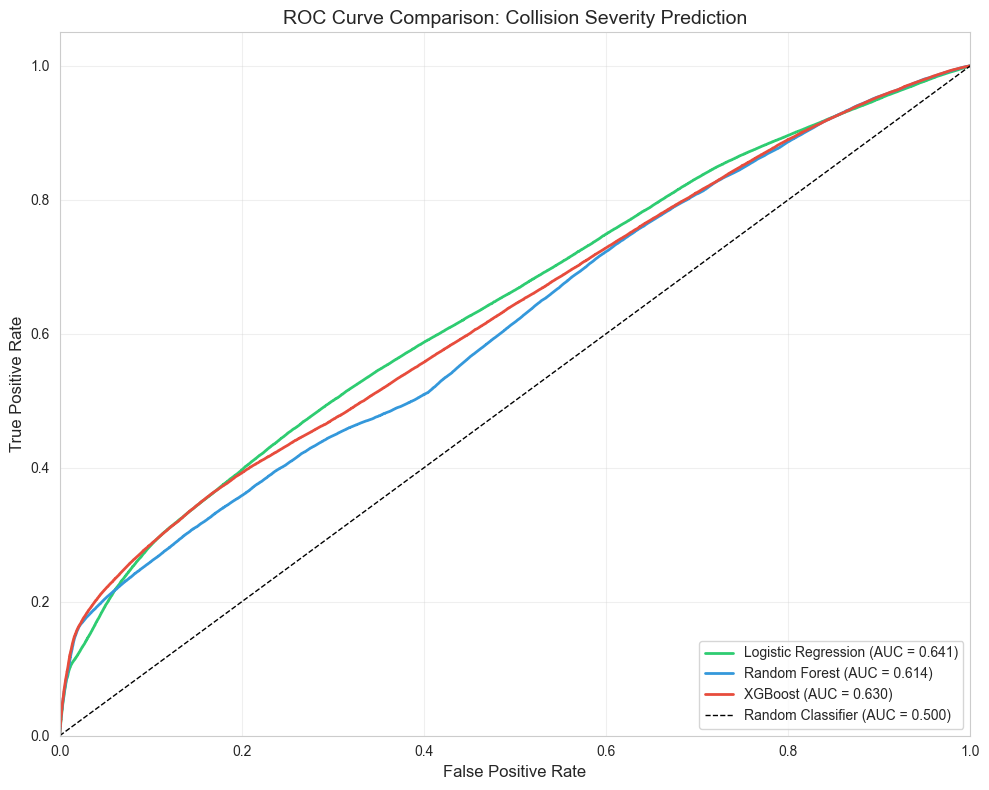

✓ ROC curves plotted


In [66]:
# =============================================================================
# ROC CURVE COMPARISON
# =============================================================================

print("=" * 70)
print("ROC CURVE COMPARISON")
print("=" * 70)

plt.figure(figsize=(10, 8))

# Plot ROC curve for each model
colors = ['#2ecc71', '#3498db', '#e74c3c']
for (name, results), color in zip(model_results.items(), colors):
    fpr, tpr, thresholds = roc_curve(y_test_binary, results['y_pred_proba'])
    auc = results['roc_auc']
    plt.plot(fpr, tpr, color=color, lw=2, label=f'{name} (AUC = {auc:.3f})')

# Plot diagonal (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=1, label='Random Classifier (AUC = 0.500)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve Comparison: Collision Severity Prediction', fontsize=14)
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("✓ ROC curves plotted")


In [67]:
# =============================================================================
# STEP 6: XGBoost Regression (severity_count)
# =============================================================================

print("=" * 70)
print("STEP 6: XGBoost Regression")
print("=" * 70)

print("\nTraining XGBRegressor...")
print("  Parameters:")
print("    - objective: reg:squarederror")
print("    - max_depth: 6")
print("    - n_estimators: 200")
print("    - learning_rate: 0.1")

# Train model
model_regression = XGBRegressor(
    objective='reg:squarederror',
    max_depth=6,
    n_estimators=200,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1,
    verbosity=1
)

print("\nFitting model on training data...")
model_regression.fit(
    X_train,
    y_train_regression,
    eval_set=[(X_train, y_train_regression), (X_test, y_test_regression)],
    verbose=False
)

print("✓ Model training complete")

# Make predictions
print("\nMaking predictions on test set...")
y_pred_regression = model_regression.predict(X_test)

print("✓ Predictions complete")

# Evaluate
print("\nEvaluating model...")
rmse = np.sqrt(mean_squared_error(y_test_regression, y_pred_regression))
mae = mean_absolute_error(y_test_regression, y_pred_regression)
r2 = r2_score(y_test_regression, y_pred_regression)

print(f"\n✓ Evaluation Metrics:")
print(f"   RMSE: {rmse:.4f}")
print(f"   MAE:  {mae:.4f}")
print(f"   R²:   {r2:.4f}")


STEP 6: XGBoost Regression

Training XGBRegressor...
  Parameters:
    - objective: reg:squarederror
    - max_depth: 6
    - n_estimators: 200
    - learning_rate: 0.1

Fitting model on training data...
✓ Model training complete

Making predictions on test set...
✓ Predictions complete

Evaluating model...

✓ Evaluation Metrics:
   RMSE: 0.8489
   MAE:  0.5544
   R²:   -0.0030


STEP 6 VALIDATION: Regression Model

1. Metrics:
   RMSE: 0.8489 (root mean squared error)
   MAE:  0.5544 (mean absolute error)
   R²:   -0.0030 (coefficient of determination)

2. Creating predicted vs actual plot...


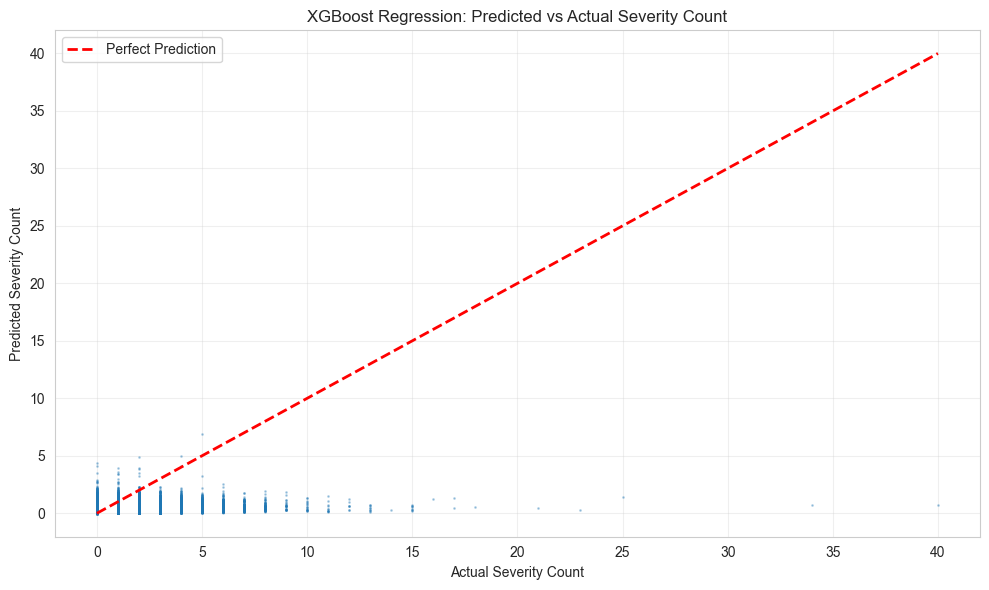


3. Analysis:
   - RMSE of 0.85 means predictions are off by ~0.85 on average (squared)
   - MAE of 0.55 means predictions are off by ~0.55 on average (absolute)
   - R² of -0.003 means the model explains -0.3% of variance

4. Prediction Tendencies:
   Under-predicted: 118,000 (40.5%)
   Over-predicted:  173,579 (59.5%)
   Exact match:     0 (0.0%)
   → Model tends to OVER-predict severity (cautious)

✓ Validation complete


In [68]:
# =============================================================================
# STEP 6 VALIDATION: Regression Results
# =============================================================================

print("=" * 70)
print("STEP 6 VALIDATION: Regression Model")
print("=" * 70)

print(f"\n1. Metrics:")
print(f"   RMSE: {rmse:.4f} (root mean squared error)")
print(f"   MAE:  {mae:.4f} (mean absolute error)")
print(f"   R²:   {r2:.4f} (coefficient of determination)")

# Plot predicted vs actual
print("\n2. Creating predicted vs actual plot...")
plt.figure(figsize=(10, 6))
plt.scatter(y_test_regression, y_pred_regression, alpha=0.3, s=1)
plt.plot([y_test_regression.min(), y_test_regression.max()], 
         [y_test_regression.min(), y_test_regression.max()], 
         'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Severity Count')
plt.ylabel('Predicted Severity Count')
plt.title('XGBoost Regression: Predicted vs Actual Severity Count')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Analysis
print("\n3. Analysis:")
print(f"   - RMSE of {rmse:.2f} means predictions are off by ~{rmse:.2f} on average (squared)")
print(f"   - MAE of {mae:.2f} means predictions are off by ~{mae:.2f} on average (absolute)")
print(f"   - R² of {r2:.3f} means the model explains {r2*100:.1f}% of variance")

# Check for under/over-prediction
under_pred = (y_pred_regression < y_test_regression).sum()
over_pred = (y_pred_regression > y_test_regression).sum()
equal_pred = (y_pred_regression == y_test_regression).sum()

print(f"\n4. Prediction Tendencies:")
print(f"   Under-predicted: {under_pred:,} ({under_pred/len(y_test_regression)*100:.1f}%)")
print(f"   Over-predicted:  {over_pred:,} ({over_pred/len(y_test_regression)*100:.1f}%)")
print(f"   Exact match:     {equal_pred:,} ({equal_pred/len(y_test_regression)*100:.1f}%)")

if under_pred > over_pred:
    print(f"   → Model tends to UNDER-predict severity (conservative)")
elif over_pred > under_pred:
    print(f"   → Model tends to OVER-predict severity (cautious)")
else:
    print(f"   → Model is balanced")

# Store metrics
regression_metrics = {
    'rmse': float(rmse),
    'mae': float(mae),
    'r2': float(r2)
}

print("\n✓ Validation complete")


STEP 7: Feature Importance Analysis

Extracting feature importance...
  Binary classification model...
  Regression model...
✓ Feature importance extracted

Top 15 features for binary classification:
  vehicle_type_1_consolidated_Bike                   | 0.2187
  contributing_factor_1_consolidated_Failure to Yield | 0.1629
  num_vehicles                                       | 0.1086
  contributing_factor_1_consolidated_Improper Maneuver | 0.0976
  contributing_factor_1_consolidated_Traffic Violation | 0.0728
  vehicle_type_1_consolidated_Motorcycle             | 0.0583
  contributing_factor_1_consolidated_Unspecified     | 0.0579
  contributing_factor_1_consolidated_Speeding        | 0.0292
  borough_MANHATTAN                                  | 0.0276
  vehicle_type_1_consolidated_Unknown                | 0.0262
  vehicle_type_1_consolidated_Truck                  | 0.0242
  vehicle_type_1_consolidated_Taxi                   | 0.0181
  contributing_factor_1_consolidated_Following Too 

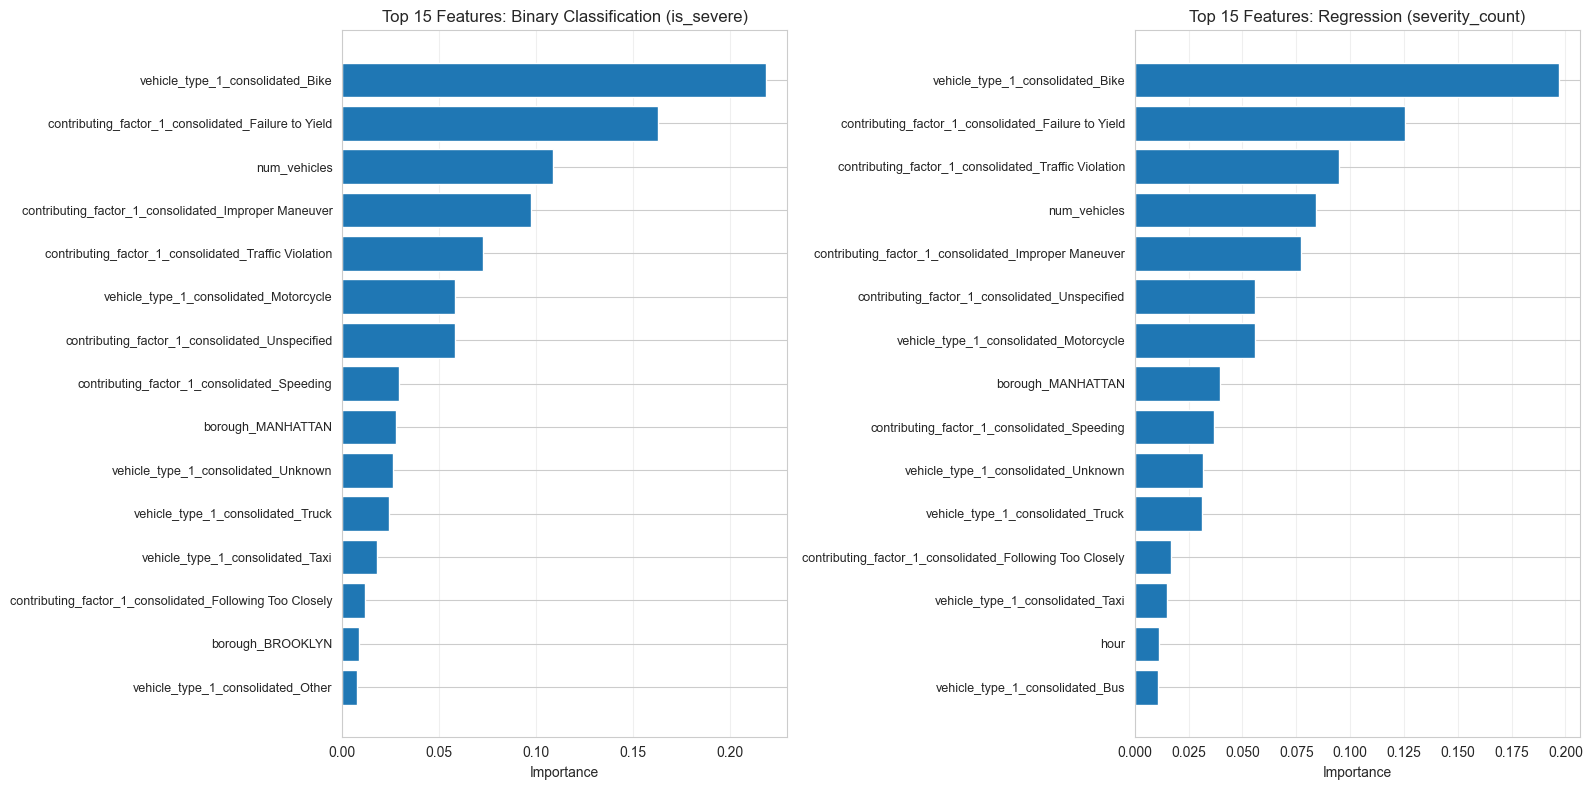

✓ Plots created


In [69]:
# =============================================================================
# STEP 7: Feature Importance Analysis
# =============================================================================

print("=" * 70)
print("STEP 7: Feature Importance Analysis")
print("=" * 70)

# Get feature importance for both models
print("\nExtracting feature importance...")

# Binary classification importance
print("  Binary classification model...")
importance_binary = model_xgb.feature_importances_
feature_importance_binary = pd.DataFrame({
    'feature': feature_names,
    'importance': importance_binary
}).sort_values('importance', ascending=False)

# Regression importance
print("  Regression model...")
importance_regression = model_regression.feature_importances_
feature_importance_regression = pd.DataFrame({
    'feature': feature_names,
    'importance': importance_regression
}).sort_values('importance', ascending=False)

print("✓ Feature importance extracted")

# Get top 15 features for each
top15_binary = feature_importance_binary.head(15)
top15_regression = feature_importance_regression.head(15)

print(f"\nTop 15 features for binary classification:")
for i, row in top15_binary.iterrows():
    print(f"  {row['feature']:50} | {row['importance']:.4f}")

print(f"\nTop 15 features for regression:")
for i, row in top15_regression.iterrows():
    print(f"  {row['feature']:50} | {row['importance']:.4f}")

# Plot feature importance
print("\nCreating feature importance plots...")

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Binary classification
axes[0].barh(range(len(top15_binary)), top15_binary['importance'].values[::-1])
axes[0].set_yticks(range(len(top15_binary)))
axes[0].set_yticklabels(top15_binary['feature'].values[::-1], fontsize=9)
axes[0].set_xlabel('Importance')
axes[0].set_title('Top 15 Features: Binary Classification (is_severe)')
axes[0].grid(True, alpha=0.3, axis='x')

# Regression
axes[1].barh(range(len(top15_regression)), top15_regression['importance'].values[::-1])
axes[1].set_yticks(range(len(top15_regression)))
axes[1].set_yticklabels(top15_regression['feature'].values[::-1], fontsize=9)
axes[1].set_xlabel('Importance')
axes[1].set_title('Top 15 Features: Regression (severity_count)')
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print("✓ Plots created")


In [70]:
# =============================================================================
# STEP 7 VALIDATION: Feature Importance Interpretation
# =============================================================================

print("=" * 70)
print("STEP 7 VALIDATION: Feature Importance Analysis")
print("=" * 70)

print("\n1. Top Features Summary:")
print("\n   Binary Classification (is_severe) - Top 5:")
for i, row in top15_binary.head(5).iterrows():
    print(f"     {i+1}. {row['feature']:45} | Importance: {row['importance']:.4f}")

print("\n   Regression (severity_count) - Top 5:")
for i, row in top15_regression.head(5).iterrows():
    print(f"     {i+1}. {row['feature']:45} | Importance: {row['importance']:.4f}")

print("\n2. Interpretation:")
print("\n   Factors that Increase Severity:")
# Analyze top features
top_binary_features = top15_binary.head(10)['feature'].tolist()
top_regression_features = top15_regression.head(10)['feature'].tolist()

# Look for patterns
print("   - Contributing factors:")
for feat in top_binary_features + top_regression_features:
    if 'contributing_factor' in feat.lower():
        print(f"     • {feat}")

print("   - Vehicle types:")
for feat in top_binary_features + top_regression_features:
    if 'vehicle_type' in feat.lower():
        print(f"     • {feat}")

print("   - Boroughs:")
for feat in top_binary_features + top_regression_features:
    if 'borough' in feat.lower():
        print(f"     • {feat}")

print("\n   Time-Based Effects:")
for feat in top_binary_features + top_regression_features:
    if any(time_feat in feat.lower() for time_feat in ['hour', 'day_of_week', 'month']):
        print(f"     • {feat}")

print("\n   Borough Differences:")
borough_features = [f for f in top_binary_features + top_regression_features if 'borough' in f.lower()]
if borough_features:
    print(f"     - {len(borough_features)} borough-related features in top 15")
    print(f"     - Suggests location is an important predictor of severity")
else:
    print("     - Borough features not in top 15")

print("\n✓ Validation complete")


STEP 7 VALIDATION: Feature Importance Analysis

1. Top Features Summary:

   Binary Classification (is_severe) - Top 5:
     7. vehicle_type_1_consolidated_Bike              | Importance: 0.2187
     19. contributing_factor_1_consolidated_Failure to Yield | Importance: 0.1629
     33. num_vehicles                                  | Importance: 0.1086
     22. contributing_factor_1_consolidated_Improper Maneuver | Importance: 0.0976
     26. contributing_factor_1_consolidated_Traffic Violation | Importance: 0.0728

   Regression (severity_count) - Top 5:
     7. vehicle_type_1_consolidated_Bike              | Importance: 0.1969
     19. contributing_factor_1_consolidated_Failure to Yield | Importance: 0.1254
     26. contributing_factor_1_consolidated_Traffic Violation | Importance: 0.0948
     33. num_vehicles                                  | Importance: 0.0840
     22. contributing_factor_1_consolidated_Improper Maneuver | Importance: 0.0772

2. Interpretation:

   Factors that Incr

In [71]:
# =============================================================================
# STEP 8: Save Artifacts
# =============================================================================

print("=" * 70)
print("STEP 8: Saving Artifacts")
print("=" * 70)

# Create artifacts directory
models_dir = Path("models")
models_dir.mkdir(exist_ok=True)
print(f"\nCreated artifacts directory: {models_dir}")

# Save models
print("\n1. Saving trained models...")
model_binary_path = models_dir / "xgb_classifier.pkl"
model_regression_path = models_dir / "xgb_regressor.pkl"

joblib.dump(model_xgb, model_binary_path)
print(f"   ✓ Saved binary classifier: {model_binary_path}")

joblib.dump(model_regression, model_regression_path)
print(f"   ✓ Saved regression model: {model_regression_path}")

# Save feature encoder
print("\n2. Saving feature encoder...")
encoder_path = models_dir / "feature_encoder.pkl"
joblib.dump(preprocessor, encoder_path)
print(f"   ✓ Saved feature encoder: {encoder_path}")

# Save metrics
print("\n3. Saving metrics...")
all_metrics = {
    'binary_classification': binary_metrics,
    'regression': regression_metrics,
    'model_info': {
        'binary': {
            'type': 'XGBClassifier',
            'max_depth': 6,
            'n_estimators': 200,
            'learning_rate': 0.1
        },
        'regression': {
            'type': 'XGBRegressor',
            'max_depth': 6,
            'n_estimators': 200,
            'learning_rate': 0.1
        }
    },
    'data_info': {
        'train_size': X_train.shape[0],
        'test_size': X_test.shape[0],
        'n_features': int(X_encoded.shape[1]),
        'train_period': f"{train_start.date()} to {train_end.date()}",
        'test_period': f"{test_start.date()} to {test_end.date()}"
    }
}

metrics_path = models_dir / "metrics.json"
with open(metrics_path, 'w') as f:
    json.dump(all_metrics, f, indent=2)
print(f"   ✓ Saved metrics: {metrics_path}")

print("\n✓ All artifacts saved successfully!")
print(f"\nArtifacts directory contents:")
for file in models_dir.iterdir():
    size_kb = file.stat().st_size / 1024
    print(f"   - {file.name} ({size_kb:.1f} KB)")


STEP 8: Saving Artifacts

Created artifacts directory: models

1. Saving trained models...
   ✓ Saved binary classifier: models/xgb_classifier.pkl
   ✓ Saved regression model: models/xgb_regressor.pkl

2. Saving feature encoder...
   ✓ Saved feature encoder: models/feature_encoder.pkl

3. Saving metrics...
   ✓ Saved metrics: models/metrics.json

✓ All artifacts saved successfully!

Artifacts directory contents:
   - metrics.json (0.8 KB)
   - xgb_regressor.pkl (965.9 KB)
   - feature_encoder.pkl (3.3 KB)
   - xgb_classifier.pkl (947.3 KB)


In [72]:
# =============================================================================
# STEP 8 VALIDATION: Verify Saved Artifacts
# =============================================================================

print("=" * 70)
print("STEP 8 VALIDATION: Artifact Verification")
print("=" * 70)

# Verify models can be loaded
print("\n1. Verifying saved models...")
try:
    loaded_binary = joblib.load(models_dir / "xgb_classifier.pkl")
    print("   ✓ Binary classifier loads successfully")
    print(f"     Type: {type(loaded_binary)}")
    
    loaded_regression = joblib.load(models_dir / "xgb_regressor.pkl")
    print("   ✓ Regression model loads successfully")
    print(f"     Type: {type(loaded_regression)}")
except Exception as e:
    print(f"   ✗ Error loading models: {e}")

# Verify encoder
print("\n2. Verifying feature encoder...")
try:
    loaded_encoder = joblib.load(models_dir / "feature_encoder.pkl")
    print("   ✓ Feature encoder loads successfully")
    print(f"     Type: {type(loaded_encoder)}")
except Exception as e:
    print(f"   ✗ Error loading encoder: {e}")

# Verify metrics
print("\n3. Verifying metrics file...")
try:
    with open(models_dir / "metrics.json", 'r') as f:
        loaded_metrics = json.load(f)
    print("   ✓ Metrics file loads successfully")
    print(f"\n   Binary Classification Metrics:")
    for key, value in loaded_metrics['binary_classification'].items():
        print(f"     {key}: {value:.4f}")
    print(f"\n   Regression Metrics:")
    for key, value in loaded_metrics['regression'].items():
        print(f"     {key}: {value:.4f}")
except Exception as e:
    print(f"   ✗ Error loading metrics: {e}")

print("\n✓ Validation complete")
print("\n" + "=" * 70)
print("PIPELINE COMPLETE!")
print("=" * 70)
print("\nAll steps completed successfully:")
print("  ✓ Step 1: Data written to SQLite")
print("  ✓ Step 2: Model-ready columns created")
print("  ✓ Step 3: Categorical features encoded")
print("  ✓ Step 4: Time-based train/test split")
print("  ✓ Step 5: XGBoost binary classification trained and evaluated")
print("  ✓ Step 6: XGBoost regression trained and evaluated")
print("  ✓ Step 7: Feature importance analyzed")
print("  ✓ Step 8: All artifacts saved")
print("\n" + "=" * 70)


STEP 8 VALIDATION: Artifact Verification

1. Verifying saved models...
   ✓ Binary classifier loads successfully
     Type: <class 'xgboost.sklearn.XGBClassifier'>
   ✓ Regression model loads successfully
     Type: <class 'xgboost.sklearn.XGBRegressor'>

2. Verifying feature encoder...
   ✓ Feature encoder loads successfully
     Type: <class 'sklearn.compose._column_transformer.ColumnTransformer'>

3. Verifying metrics file...
   ✓ Metrics file loads successfully

   Binary Classification Metrics:
     accuracy: 0.5794
     precision: 0.4912
     recall: 0.6314
     f1: 0.5525
     roc_auc: 0.6412

   Regression Metrics:
     rmse: 0.8489
     mae: 0.5544
     r2: -0.0030

✓ Validation complete

PIPELINE COMPLETE!

All steps completed successfully:
  ✓ Step 1: Data written to SQLite
  ✓ Step 2: Model-ready columns created
  ✓ Step 3: Categorical features encoded
  ✓ Step 4: Time-based train/test split
  ✓ Step 5: XGBoost binary classification trained and evaluated
  ✓ Step 6: XGBoost

In [73]:
# Check class balance for is_severe
severe_counts = df_model['is_severe'].value_counts()
total = len(df_model)
for val, count in severe_counts.items():
    pct = (count / total) * 100
    label = "Severe" if val == 1 else "Not Severe"
    print(f"{label}: {count:,} ({pct:.1f}%)")


Not Severe: 1,682,159 (75.6%)
Severe: 542,483 (24.4%)
